In [1]:
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np

In [2]:
img_path = 'Imagenet/' 
#for this code to run, one need a sub set of the imagenet dataset organized in folders correspondings to classes

import scipy.io
import os
from keras.preprocessing import image
import numpy as np


In [4]:
import time

In [5]:

debug_imgs_path = 'debug_imgs/' #path to access random image to be loaded on RAM

img_name_list  = os.listdir(debug_imgs_path)
NB_IMG = len(img_name_list)
print(NB_IMG)

TRAIN_SIZE = int(0.8*NB_IMG)
TEST_SIZE = NB_IMG-TRAIN_SIZE


t1 = time.time()
debug_imgs = np.zeros((100, 224, 224, 3), dtype='float16')
i = 0
for file in img_name_list[:100]:
    if not('JPEG' in file):
        continue
    train_image = image.load_img(debug_imgs_path+file, target_size = (224, 224))
    train_image = image.img_to_array(train_image)
    debug_imgs[i, : ,: ,:] = train_image
    i+=1
    if i%100 == 0:
        print(i)

debug_imgs *= 1/255.
t2 = time.time()
print(t2-t1)

102
8.439761638641357


## Define image generators

In [7]:
import json
f = open('imagenet_classes.txt', 'r')
txt = f.read()
imagenet_classes = json.loads(txt)
f.close()

In [8]:
imagenet_classes_inception ={}


for k,v in imagenet_classes.items():
    imagenet_classes_inception[v] = int(k)

In [9]:
Batch_size = 64
IMG_SIZE = 224
print("Creating datagenerators ...")
i1_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

i2_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        validation_split=0.2)

i2_generator = i2_datagen.flow_from_directory(
        img_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=Batch_size,
        class_mode="categorical", subset='training',
        classes=imagenet_classes_inception)


i1_generator = i1_datagen.flow_from_directory(
        img_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=Batch_size,
        class_mode="categorical", subset='training',

i1_test_generator = i1_datagen.flow_from_directory(
        img_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=Batch_size,
        class_mode="categorical", subset='validation',
        classes=imagenet_classes_inception)

i2_test_generator = i2_datagen.flow_from_directory(
        img_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=Batch_size,
        class_mode="categorical", subset='validation',
        classes=imagenet_classes_inception)




beg
datagen
Found 40000 images belonging to 1000 classes.
Found 40000 images belonging to 1000 classes.
test
Found 10000 images belonging to 1000 classes.
end


In [98]:
class TupleImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, i1_gen, i2_gen):
        self.i1_gen = i1_gen
        self.i2_gen = i2_gen

    def __len__(self):
        return self.i1_gen.__len__()

    def __getitem__(self, index):
        img1, y1 = self.i1_gen.__getitem__(index)
        img2, y2 = self.i2_gen.__getitem__(index)
        X = [img1, img2]
        return X, y1 ##y1 en vrai

    def on_epoch_end(self):
        self.i1_gen.on_epoch_end()
        self.i2_gen.on_epoch_end()


    

In [11]:
train_data_gen = TupleImageGenerator(i1_generator, i2_generator)
test_data_gen = TupleImageGenerator(i1_test_generator, i2_test_generator)


In [99]:
test_data_gen2 = TupleImageGenerator(i1_test_generator, i2_test_generator)

## Load MobileNet

In [12]:
classif_model = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)


In [13]:
for layer in classif_model.layers:
    layer.trainable = False

In [13]:
(i1,i2), y = train_data_gen.__getitem__(0)

In [14]:
preds = classif_model.predict(i1[:5])

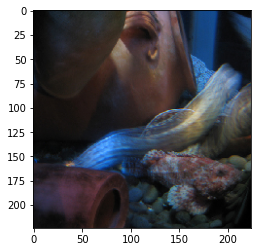

In [15]:
plt.imshow(i1[4])
plt.show()

# Non robust feature transfer

In [ ]:
IMG_SIZE = 224

### Define combinator

In [89]:
from keras.layers import Dropout

combi = Sequential()
combi.add(Conv2D(50, (4,4), padding='same', input_shape=(IMG_SIZE,IMG_SIZE,6),  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(50, (4,4), padding='same', activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(50, (4,4), padding='same', activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(50, (4,4), padding='same',  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(3, (4,4), padding='same',  activation=None) )
combi.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 224, 224, 50)      4850      
                                                                 
 dropout_40 (Dropout)        (None, 224, 224, 50)      0         
                                                                 
 conv2d_56 (Conv2D)          (None, 224, 224, 50)      40050     
                                                                 
 dropout_41 (Dropout)        (None, 224, 224, 50)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 224, 224, 50)      40050     
                                                                 
 dropout_42 (Dropout)        (None, 224, 224, 50)      0         
                                                                 
 conv2d_58 (Conv2D)          (None, 224, 224, 50)    

### Define nrfExtractor

In [73]:
val_acc = []
train_acc = []

val_loss = []
train_loss = []



class LogCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc.append(logs["accuracy"])
        train_loss.append(logs["Raw mean L2 distance to image"])
        val_acc.append(logs["val_accuracy"])
        val_loss.append(logs["val_Raw mean L2 distance to image"])
        print(logs.keys())
        

def reset_logs():
  val_acc = []
  train_acc = []

  val_loss = []
  train_loss = []

In [74]:
def plot_learning_curves():
  f, p = plt.subplots(2,1, figsize=(15,10))
  p[0].plot(train_acc, label="Training accuracy")
  p[0].plot(val_acc, label="Validation accuracy")
  p[0].set_xlabel("epoch")
  p[0].legend()

  p[1].plot(train_loss, label="Training Raw mean L2 distance to image")
  p[1].plot(val_loss, label="Validation Raw mean L2 distance to image")
  p[1].set_xlabel("epoch")
  p[1].legend()

In [75]:
class NRFextractor(keras.Model):
    def __init__(self,  classifier,epsilon=0.0,classif_w = 1.,dist_w=1.,filter=None, combi=None,sig_act_filter=True,usefilter=True, **kwargs):
        super(NRFextractor, self).__init__(**kwargs)

        self.usefilter = usefilter
        self.filter = filter
        self.classifier = classifier #pretrained classifier
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.cla_loss_tracker = keras.metrics.Mean(name="classification loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distance to image loss")
        self.dist_tracker = keras.metrics.Mean(name="Raw mean L2 distance to COVER image (to minimize)")
        self.dist_to_hidden_tracker = keras.metrics.Mean(name="Mean L2 distance to HIDDEN image")

        self.acc_tracker = tf.keras.metrics.CategoricalAccuracy(name="accuracy")
        self.epsilon = epsilon
        self.sig_act_filter = sig_act_filter
        self.classif_w = classif_w
        self.dist_w = dist_w

        if combi is not None:
          self.combinator = combi
          self.custom_combi = True
          self.sig_act_filter = False
        else:
          self.custom_combi = False

        self.acc_history = []
        self.loss_history = []


        self.val_acc_history = []
        self.val_loss_history = []

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.acc_tracker,
            self.cla_loss_tracker,
            self.dist_loss_tracker,
            self.dist_tracker,
            self.dist_to_hidden_tracker
        ]
    
    @tf.function
    def call(self, data):
      i1, i2 = data
      if self.usefilter:
        if self.sig_act_filter:
          nrf = 2*(self.filter(i1)-0.5) 
        else:
          nrf =  self.filter(i1)
      else:
        nrf = i1

      if self.custom_combi:
        imgs = tf.concat([nrf, i2],axis=-1)
        img = self.combinator(imgs)
      else:
        img = self.epsilon*nrf+(1-self.epsilon)*i2

      out = self.classifier(img)
      return out

    @tf.function
    def train_step(self, data):
        imgs, y1 = data #y1 : labels of the hidden image
        i1, i2 = imgs #i1 :  hidden image, i2: cover image

        with tf.GradientTape(persistent=False) as tape:
          if self.usefilter:
            if self.sig_act_filter:
              nrf = 2*(self.filter(i1)-0.5) 
            else:
              nrf =  self.filter(i1)
          else:
            nrf = i1

          if self.custom_combi:
            imgs = tf.concat([nrf, i2],axis=-1)
            img = self.combinator(imgs)
          else:
            img = self.epsilon*nrf+(1-self.epsilon)*i2

          out = self.classifier(img)
          
          cla_loss = tf.keras.losses.binary_crossentropy(out, y1)

          if self.custom_combi:
            distance_to_cov_img = tf.reduce_sum( tf.square(i2-img ))
          else:
            distance_to_cov_img = 0

          loss = distance_to_cov_img*self.dist_w + self.classif_w * cla_loss

        if self.usefilter:
          grads_filter = tape.gradient(loss, self.filter.weights)
          self.optimizer.apply_gradients(zip(grads_filter, self.filter.weights))

        grads_combi = tape.gradient(loss, self.combinator.weights)

        
        self.optimizer.apply_gradients(zip(grads_combi, self.combinator.weights))
        self.loss_tracker.update_state(loss)
        self.cla_loss_tracker.update_state(self.classif_w *cla_loss)
        self.dist_loss_tracker.update_state(distance_to_cov_img*self.dist_w)
        self.dist_tracker.update_state(tf.reduce_mean( tf.square(i2-img )))
        self.dist_to_hidden_tracker.update_state(tf.reduce_mean( tf.square(i1-img )))

        self.acc_tracker.update_state(out, y1)
        return {m.name: m.result() for m in self.metrics}

    def get_img_to_classify(self, imgs):
      i1, i2 = data
      if self.usefilter:
        if self.sig_act_filter:
          nrf = 2*(self.filter(i1)-0.5) 
        else:
          nrf =  self.filter(i1)
      else:
        nrf = i1

      if self.custom_combi:
        imgs = tf.concat([nrf, i2],axis=-1)
        img = self.combinator(imgs)
      else:
        img = self.epsilon*nrf+(1-self.epsilon)*i2
      return img


    @tf.function
    def test_step(self, data):
        imgs, y1 = data
        i1, i2 = imgs
        if self.usefilter:
          if self.sig_act_filter:
            nrf = 2*(self.filter(i1)-0.5) 
          else:
            nrf =  self.filter(i1)
        else:
          nrf = i1

        if self.custom_combi:
          imgs = tf.concat([nrf, i2],axis=-1)
          img = self.combinator(imgs)
        else:
          img = self.epsilon*nrf+(1-self.epsilon)*i2

        out = self.classifier(img)
        cla_loss = tf.keras.losses.binary_crossentropy(out, y1)

        if self.custom_combi:
          distance_to_cov_img = tf.reduce_sum( tf.square((i2-img) ))
        else:
          distance_to_cov_img = 0

        loss = distance_to_cov_img + self.classif_w * cla_loss

        self.loss_tracker.update_state(loss)
        self.cla_loss_tracker.update_state(loss)
        self.dist_loss_tracker.update_state(distance_to_cov_img*self.dist_w)
        self.dist_tracker.update_state(tf.reduce_mean( tf.square((i2-img) )))
        self.dist_to_hidden_tracker.update_state(tf.reduce_mean( tf.square((i1-img) )))
        self.acc_tracker.update_state(out, y1)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}



## Create and train nrfExtractor

In [76]:
import datetime

In [90]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                                                 histogram_freq = 1,
                                                 update_freq = 'batch',
                                                 profile_batch = '2,12') #tensorboard callback to improve the performances


In [91]:
checkpoint_filepath = 'checkpoints/weights.{epoch:02d}-{batch:02d}-{accuracy:.4f}-{Raw mean L2 distance to COVER image (to minimize):.4f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=100,
    save_best_only=False,
    verbose=1)

In [116]:
nrfXT = NRFextractor(classif_model, classif_w = 9e6,dist_w=5e-2, combi=combi,sig_act_filter=False, usefilter=False)
boundaries = [500,1500] #5e6 trop grand , 1e7 trop grand 1e6 trop petit
values = [0.002, 0.0005, 0.0001]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
nrfXT.compile(metrics=['accuracy', 'loss', 'classification loss', 
                'distance to image loss', 'Raw mean L2 distance to image' ], optimizer=opt_adam)

In [117]:
nrfXT.fit(train_data_gen, 
            epochs=20, validation_data=test_data_gen, 
            callbacks=[ tensorboard_callback,model_checkpoint_callback], verbose=1)

# Evaluate the models

In [ ]:
os.mkdir("good_models")

In [ ]:
score = nrfXT.evaluate(test_data_gen2, verbose=1)

In [62]:
img1 = [i1_test_generator.__getitem__(j)[0] for j in range(N)]

In [44]:
np.random.randint(0,10)

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

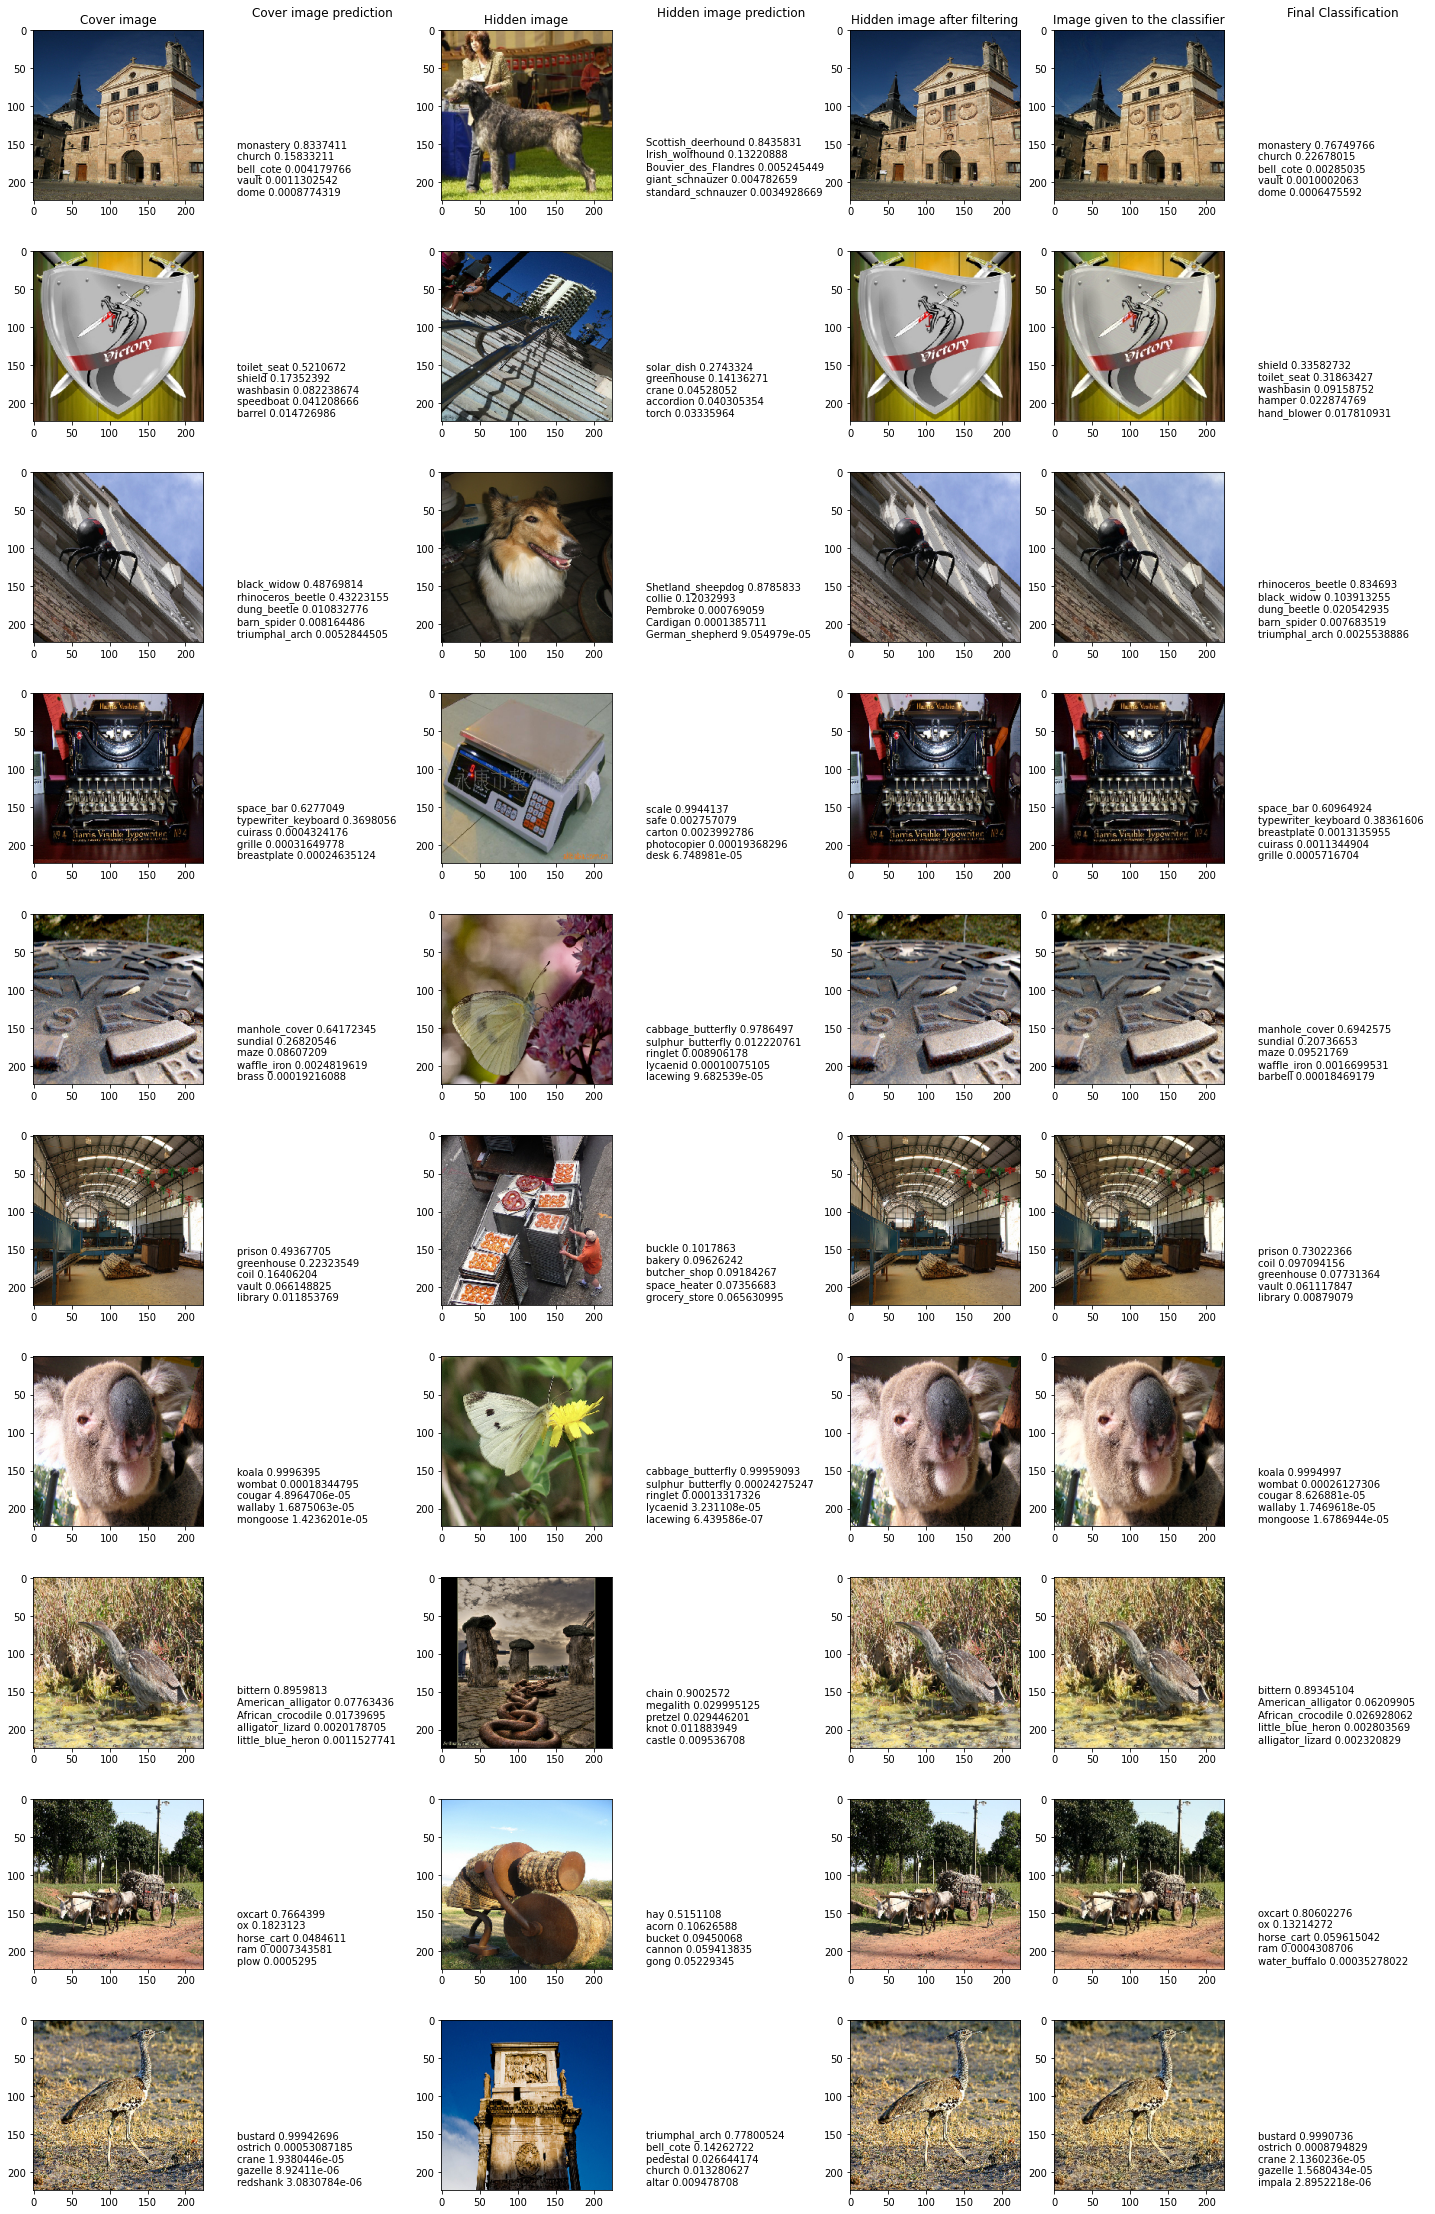

In [115]:



N=10

d = np.random.randint(0,100)
img1 = i1_test_generator.__getitem__(d+2)[0][:N]
img2 = i2_test_generator.__getitem__(d+2)[0][:N]


y_pred = nrfXT.predict([img1, img2])
pred_labels = clean_decode(y_pred, top=5)


pre_classifier_img = nrfXT.combinator.predict(np.concatenate([ img1, img2], axis=-1))

cover_img_pred = clean_decode(classif_model.predict(img2))
hidden_img_pred = clean_decode(classif_model.predict(img1))


f, axarr = plt.subplots(N,7, figsize=(25,N*4))

for i in range(N):


  if i == 0:
    axarr[i][0].set_title("Cover image")
    axarr[i][1].set_title("Cover image prediction")

    axarr[i][2].set_title("Hidden image")
    axarr[i][3].set_title("Hidden image prediction")

    axarr[i][4].set_title("Hidden image after filtering")

    axarr[i][5].set_title("Image given to the classifier")

    axarr[i][6].set_title("Final Classification")

  axarr[i][0].imshow(img2[i])

  axarr[i][1].text(0,0,cover_img_pred[i])
  axarr[i][1].axis("off")

  axarr[i][2].imshow(img1[i])

  axarr[i][3].text(0,0,hidden_img_pred[i])
  axarr[i][3].axis("off")

  axarr[i][4].imshow(img2[i])

  axarr[i][5].imshow(pre_classifier_img[i])

  axarr[i][6].text(0,0,pred_labels[i])
  axarr[i][6].axis("off")

